# IBM_SKILLSBUILD_NAAN_MUDHALVAN_GEN_AI_PROJECT:
# **LSTM_Sentiment_Analysis_AirlineReviews:**
AUTHOR:J EMMANUAL JUDE ANTONY

REG.NO:211521243053

IMPORTING DATASET:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
path="/content/drive/MyDrive/airline_sentiment.csv"
df=pd.read_csv(path)
df.head()

,airline_sentiment,text
0,1,@VirginAmerica plus you've added commercials t...
1,0,@VirginAmerica it's really aggressive to blast...
2,0,@VirginAmerica and it's a really big bad thing...
3,0,@VirginAmerica seriously would pay $30 a fligh...
4,1,"@VirginAmerica yes, nearly every time I fly VX..."


IMPORTING LIBRARIES:

In [4]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
pip install projectpro

In [6]:
# Import relevant packages
import os
from collections import Counter

import tensorflow as tf
from keras.layers import Dense, Activation
from keras.layers import SimpleRNN, LSTM, GRU
from keras.models import Sequential
from keras.utils import to_categorical, pad_sequences
from keras.layers import Embedding

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import numpy as np
import nltk
import re
from projectpro import save_point, checkpoint

from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

In [7]:
pd.set_option('display.max_colwidth', None)
tf.keras.backend.set_image_data_format("channels_last")
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

CREATING PROCESS DATASET:

In [8]:
import nltk
import re
from collections import Counter
from nltk.corpus import stopwords
from keras.utils import pad_sequences
import numpy as np

# Download the stopwords data from NLTK
nltk.download('stopwords')

# Get a list of English stopwords
stop = stopwords.words('english')

# Function to preprocess text data
def pre_process_text_data(text):
    # Normalize and remove special characters
    text = text.lower()
    text = re.sub('[^0-9a-zA-Z]+', ' ', text)

    # Remove stopwords
    words = text.split()
    words = [w for w in words if w not in stop]
    words = ' '.join(words)

    return words

# Function to preprocess and tokenize text data in a DataFrame
def process_data(df):
    # Preprocess text data in the DataFrame
    df['text'] = df['text'].apply(pre_process_text_data)

    # Count words in the preprocessed text
    counts = Counter()
    for i, review in enumerate(df['text']):
        counts.update(review.split())

    words = sorted(counts, key=counts.get, reverse=True)

    return df, words

# Function to convert text to a list of integers based on a word-to-int mapping
def text_to_int(text, word_to_int):
    return [word_to_int[word] for word in text.split()]

# Function to convert a list of integers back to text
def int_to_text(int_arr, int_to_word):
    return ' '.join([int_to_word[index] for index in int_arr if index != 0])

# Function to map reviews to sequences of integers
def map_reviews(df, word_to_int):
    mapped_reviews = []
    for review in df['text']:
        mapped_reviews.append(text_to_int(review, word_to_int))

    return mapped_reviews

# Function to get the maximum sequence length among mapped reviews
def get_sequence_length(mapped_reviews):
    length_sent = [len(review) for review in mapped_reviews]
    sequence_length = max(length_sent)

    return sequence_length

# Function to pad and encode mapped reviews
def pad_and_encode(mapped_reviews, sequence_length):
    X = pad_sequences(maxlen=sequence_length, sequences=mapped_reviews, padding="post", value=0)

    return X

# Function to process sentiment data, returning X (padded and encoded reviews), y (sentiment labels),
# word-to-int and int-to-word mappings
def process_sentiment_data(df):
    df, words = process_data(df)

    # Create word-to-int and int-to-word mappings
    word_to_int = {word: i for i, word in enumerate(words, start=1)}
    int_to_word = {i: word for i, word in enumerate(words, start=1)}

    # Map reviews to sequences of integers
    mapped_reviews = map_reviews(df, word_to_int)

    # Get the maximum sequence length among mapped reviews
    sequence_length = get_sequence_length(mapped_reviews)

    # Pad and encode the mapped reviews
    X = pad_and_encode(mapped_reviews, sequence_length)

    # Get sentiment labels
    y = df['airline_sentiment'].values

    return X, y, word_to_int, int_to_word

# Additional functions for text generation

# Function to preprocess text for text generation
def pre_process(text: str) -> str:
    text = text.lower()
    text = re.sub('[^0-9a-zA-Z]+', ' ', text)
    return text

# Function to get input and label words for text generation
def get_input_and_labels(text: str, seq_length: int = 10, step: int = 1):
    input_words = []
    label_words = []

    text_arr = text.split()

    for i in range(0, len(text_arr) - seq_length, step):
        x = text_arr[i : (i + seq_length)]
        y = text_arr[i + seq_length]
        input_words.append(x)
        label_words.append(y)

    return input_words, label_words

# Function to process text data for text generation, returning X (input words) and y (label words)
def process_text_generation_data(text: str, seq_length: int = 10):
    processed_text = pre_process(text)
    input_words, label_words = get_input_and_labels(processed_text, seq_length=seq_length)

    counts = Counter()
    counts.update(processed_text.split())
    words = sorted(counts, key=counts.get, reverse=True)
    nb_words = len(processed_text.split())

    word2index = {word: i for i, word in enumerate(words)}
    index2word = {i: word for i, word in enumerate(words)}

    total_words = len(set(words))

    # Create input and label arrays for text generation
    X = np.zeros((len(input_words), seq_length, total_words), dtype=bool)
    y = np.zeros((len(input_words), total_words), dtype=bool)

    for i, input_word in enumerate(input_words):
        for j, word in enumerate(input_word):
            X[i, j, word2index[word]] = 1
        y[i, word2index[label_words[i]]] = 1

    return X, y, words, nb_words, total_words, word2index, index2word, input_words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


TRAINING DATASET CREATION:

In [9]:
import os
from collections import Counter
import tensorflow as tf
from keras.layers import Dense, Activation, SimpleRNN, LSTM, GRU
from keras.models import Sequential
from keras.utils import to_categorical, pad_sequences
from keras.layers import Embedding
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import numpy as np
import nltk
import re
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

# Set display options for Pandas
pd.set_option('display.max_colwidth', None)

# Set the image data format for TensorFlow
tf.keras.backend.set_image_data_format("channels_last")

# Download the stopwords data from NLTK
nltk.download('stopwords')

# Import necessary modules for the text generation part
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Function to train a sentiment analysis LSTM model
def train_sentiment_lstm(X_train, y_train, X_test, y_test, word_to_int, embedding_dim=32, lstm_units=40, epochs=50, batch_size=32):
    # Create the LSTM model
    model = Sequential()
    model.add(Embedding(input_dim=len(word_to_int) + 1, output_dim=embedding_dim, input_length=X_train.shape[1]))
    model.add(LSTM(units=lstm_units, return_sequences=True))
    model.add(LSTM(units=lstm_units, return_sequences=False))
    model.add(Dense(units=2, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Print model summary
    print(model.summary())

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)

    # Print training history
    print('Training Loss:', history.history['loss'])
    print('Validation Loss:', history.history['val_loss'])
    print('Training Accuracy:', history.history['accuracy'])
    print('Validation Accuracy:', history.history['val_accuracy'])

    # Save the model
    model.save('output/sentiment_model.h5')
    return model

# Constants for text generation
SEQLEN = 10
STEP = 1

# Function to create a text generation model
def create_text_generation_model(hidden_size, seq_length, total_words):
    model = Sequential()
    model.add(LSTM(hidden_size, return_sequences=False, input_shape=(seq_length, total_words)))
    model.add(Dense(total_words, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    return model

# Constants for text generation
BATCH_SIZE = 32
NUM_ITERATIONS = 100
NUM_EPOCHS_PER_ITERATION = 1
NUM_PREDS_PER_EPOCH = 100

# Function to check model output during text generation
def check_model_output(model, preds: int, input_words, seq_length, total_words, word2index, index2word):
    test_idx = np.random.randint(int(len(input_words) * 0.1)) * (-1)
    test_words = input_words[test_idx]

    for curr_pred in range(preds):
        curr_embedding = np.zeros((1, seq_length, total_words))

        for i, ch in enumerate(test_words):
            curr_embedding[0, i, word2index[ch]] = 1

        pred = model.predict(curr_embedding, verbose=0)[0]
        word_pred = index2word[np.argmax(pred)]

        print("=" * 50)
        print(f"Prediction {curr_pred + 1} of {preds}")
        print(f'Generating from seed: {" ".join(test_words)}\nNext Word: {word_pred}')
        print("=" * 50)

        test_words = test_words[1:] + [word_pred]

# Function to train a text generation model
def train_text_generation_model(X, y, input_words, seq_length, total_words, model, word2index, index2word):

    for iteration in range(NUM_ITERATIONS):
        model.fit(X, y, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS_PER_ITERATION, validation_split=0.1)
        if iteration % 10 == 0:
            check_model_output(model, 5, input_words, seq_length, total_words, word2index, index2word)

    # Save the trained model
    model.save('output/text_gen_model.h5')
    return model

# Function to predict the next word during text generation
def predict_next_word(model, input_text: str, seq_length, total_words, word2index, index2word, temperature=None):
    curr_embedding = np.zeros((1, seq_length, total_words))

    for i, ch in enumerate(input_text):
        curr_embedding[0, i, word2index[ch]] = 1

    pred = model.predict(curr_embedding, verbose=0)[0]

    if temperature == None:
        word_pred = index2word[np.argmax(pred)]
    else:
        next_word_token = tf.random.categorical(tf.expand_dims(pred / temperature, 0), num_samples=1)[-1, 0].numpy()
        word_pred = index2word[next_word_token]

    return pred, word_pred

# Function to generate a paragraph of text
def generate_paragraph(model, seed, words: int, temperature: int, total_words, word2index, index2word):
    full_text = seed.copy()
    for _ in range(words):
        logits, word_pred = predict_next_word(model, seed, SEQLEN, total_words, word2index, index2word, temperature=temperature)
        seed = (seed + [word_pred])[-10:]
        full_text = full_text + [word_pred]
    return full_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


UTILITIES:

In [ ]:
from collections import Counter

# Function to convert text to a list of integers based on a word-to-int mapping
def text_to_int(text: str, word_to_int: dict):
    return [word_to_int[word] for word in text.split()]

# Function to convert a list of integers back to text
def int_to_text(int_arr, int_to_word: dict):
    return ' '.join([int_to_word[index] for index in int_arr if index != 0])

import numpy as np
from keras.utils import to_categorical, pad_sequences
from keras.models import load_model

import numpy as np

# Function to get sentiment for a given text using a trained model
def get_sentiment(model, text, word_to_int, int_to_word, sequence_length):
    text_int_embedding = text_to_int(text, word_to_int)
    text_int_embedding = pad_sequences(maxlen=sequence_length, sequences=[text_int_embedding], padding="post", value=0)
    sentiment_index = np.argmax(model.predict(text_int_embedding))
    return sentiment_index

# Function to get predicted sentiments for a list of text embeddings
def get_predicted_sentiments(model, X_test, int_to_word):
    result = np.argmax(model.predict(X_test), axis=1)
    positive_sentences = [int_to_text(embedding, int_to_word) for i, embedding in enumerate(X_test) if result[i] == 1]
    negative_sentences = [int_to_text(embedding, int_to_word) for i, embedding in enumerate(X_test) if result[i] == 0]
    return positive_sentences, negative_sentences

# Function to load text data from a file (default filename is 'data/alice.txt')
def load_data(filename: str = 'data/alice.txt'):
    with open(filename, encoding='utf-8-sig') as fin:
        lines = []
        for line in fin:
            line = line.strip().lower()
            if len(line) == 0:
                continue
            lines.append(line)
        fin.close()
        text = " ".join(lines)
    return text

**DATA PREPROCESSING:**

Removing Stop Words:

In [ ]:
stop = nltk.corpus.stopwords.words('english')

In [ ]:
def pre_process_text_data(text: str) -> str:
    # Convert the text to lowercase
    text = text.lower()

    # Remove special characters and symbols using a regular expression
    text = re.sub('[^0-9a-zA-Z]+', ' ', text)

    # Tokenize the text into words
    words = text.split()

    # Filter out stopwords (common words that may not contribute much to the text's meaning)
    words = [w for w in words if (w not in stop)]

    # Rejoin the filtered words to form a preprocessed text
    words = ' '.join(words)

    return words

In [ ]:
df['text'] = df['text'].apply(pre_process_text_data)
df.head()

,airline_sentiment,text
0,1,virginamerica plus added commercials experience tacky
1,0,virginamerica really aggressive blast obnoxious entertainment guests faces amp little recourse
2,0,virginamerica really big bad thing
3,0,virginamerica seriously would pay 30 flight seats playing really bad thing flying va
4,1,virginamerica yes nearly every time fly vx ear worm go away


Checking Most Used Words:

In [ ]:
# Create a Counter object to count word occurrences in text reviews
counts = Counter()

# Loop through the text reviews in the DataFrame and update the word counts
for i, review in enumerate(df['text']):
    counts.update(review.split())

In [ ]:
words = sorted(counts, key=counts.get, reverse=True)

# Select and print the top 10 most frequent words
top_10_words = words[0:10]
print(top_10_words)

['united', 'flight', 'usairways', 'americanair', 'southwestair', 'jetblue', 'get', 'cancelled', 'thanks', 'service']


Creating Numeric Representation of Words (Bag of Words):

In [ ]:
# Create a dictionary that maps words to unique integer values, starting from 1
word_to_int = {word: i for i, word in enumerate(words, start=1)}

# Create a dictionary that maps integer values to words
int_to_word = {i: word for i, word in enumerate(words, start=1)}

In [ ]:
def text_to_int(text: str, word_to_int: dict):
    # Split the input text into words and convert each word to its corresponding integer using the word_to_int dictionary
    return [word_to_int[word] for word in text.split()]

def int_to_text(int_arr, int_to_word: dict):
    # Join the list of integers into a string of words, using the int_to_word dictionary to map integers back to words
    return ' '.join([int_to_word[index] for index in int_arr if index != 0])

In [ ]:
mapped_reviews = []

# Loop through the text reviews in the DataFrame and convert each review to a list of integers using text_to_int function
for review in df['text']:
    mapped_reviews.append(text_to_int(review, word_to_int))

In [ ]:
print(f'Original text: {df.loc[0]["text"]}')

# Print the mapped version of the text from the first review
print(f'Mapped text: {mapped_reviews[0]}')

Original text: virginamerica plus added commercials experience tacky
Mapped text: [44, 450, 1142, 2233, 100, 5429]


In [ ]:
length_sent = []

# Loop through the mapped reviews and calculate the length (number of words) of each review
for i in range(len(mapped_reviews)):
    length_sent.append(len(mapped_reviews[i]))

Checking sequence length and padding accordingly:

In [ ]:
# Calculate the sequence_length as the maximum length among all mapped reviews
sequence_length = max(length_sent)

# Use the pad_sequences function to pad the mapped_reviews
X = pad_sequences(maxlen=sequence_length, sequences=mapped_reviews, padding="post", value=0)

In [ ]:
X[0]

array([  44,  450, 1142, 2233,  100, 5429,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0], dtype=int32)

In [ ]:
y = df['airline_sentiment'].values

CREATING LSTM MODEL:

In [ ]:
# Set the embedding vector length to 32
embedding_vecor_length = 32

# Set the maximum review length to 26
max_review_length = 26

In [ ]:
model = Sequential()

# Add an embedding layer with an input dimension of 12533, output dimension of 32, and input length of 26
model.add(Embedding(input_dim=12533, output_dim=32, input_length=26))

# Add the first LSTM layer with 40 units and return sequences (used for stacking LSTM layers)
model.add(LSTM(40, return_sequences=True))

# Add the second LSTM layer with 40 units and return sequences set to False (final LSTM layer)
model.add(LSTM(40, return_sequences=False))

# Add a Dense layer with 2 units and softmax activation (common for binary classification)
model.add(Dense(2, activation='softmax'))

# Compile the model with categorical cross-entropy loss and the Adam optimizer, and measure accuracy during training
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 26, 32)            401056    
                                                                 
 lstm (LSTM)                 (None, 26, 40)            11680     
                                                                 
 lstm_1 (LSTM)               (None, 40)                12960     
                                                                 
 dense (Dense)               (None, 2)                 82        
                                                                 
Total params: 425778 (1.62 MB)
Trainable params: 425778 (1.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Preparing data for training and validation:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=10)

One-hot-encoding:

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Training:

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

Epoch 1/50
253/253 [==============================] - 16s 40ms/step - loss: 0.3400 - accuracy: 0.8663 - val_loss: 0.2104 - val_accuracy: 0.9108
Epoch 2/50
253/253 [==============================] - 10s 39ms/step - loss: 0.1397 - accuracy: 0.9468 - val_loss: 0.2179 - val_accuracy: 0.9108
Epoch 3/50
253/253 [==============================] - 11s 43ms/step - loss: 0.0752 - accuracy: 0.9767 - val_loss: 0.2577 - val_accuracy: 0.9076
Epoch 4/50
253/253 [==============================] - 9s 36ms/step - loss: 0.0428 - accuracy: 0.9877 - val_loss: 0.2530 - val_accuracy: 0.9105
Epoch 5/50
253/253 [==============================] - 9s 35ms/step - loss: 0.0350 - accuracy: 0.9902 - val_loss: 0.3762 - val_accuracy: 0.9038
Epoch 6/50
253/253 [==============================] - 11s 42ms/step - loss: 0.0246 - accuracy: 0.9937 - val_loss: 0.4260 - val_accuracy: 0.9082
Epoch 7/50
253/253 [==============================] - 9s 37ms/step - loss: 0.0206 - accuracy: 0.9949 - val_loss: 0.4349 - val_accuracy: 0.

In [ ]:
%matplotlib inline

# Extract the training history from the 'history' object
history_dict = history.history

# Extract the training and validation loss values
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# Extract the training and validation accuracy values
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

# Define the range of epochs
epochs = range(1, len(val_loss_values) + 1)

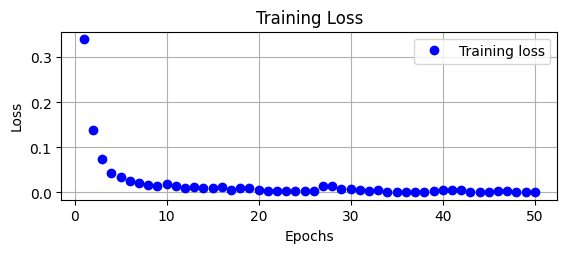

In [ ]:
plt.subplot(211)

# Plot the training loss as blue dots ('bo')
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')

plt.show()

<ipython-input-37-78fc919a1ae7>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])


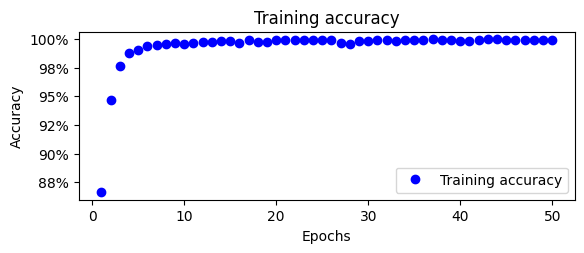

In [ ]:
plt.subplot(212)

# Plot the training accuracy as blue dots ('bo')
plt.plot(epochs, history.history['accuracy'], 'bo', label='Training accuracy')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Format the y-axis tick labels to display percentages
plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid(False)

plt.show()

Anecdotes:

In [ ]:
def get_sentiment(model, text) -> str:
    # Convert the input text to a list of integers using the text_to_int function
    text_int_embedding = text_to_int(text, word_to_int)

    # Pad the list of integers to match the sequence length
    text_int_embedding = pad_sequences(maxlen=sequence_length, sequences=[text_int_embedding], padding="post", value=0)

    # Predict the sentiment using the model and get the index of the predicted class
    sentiment_index = np.argmax(model.predict(text_int_embedding))

    # Return the sentiment index as a string
    return sentiment_index

In [ ]:
result = np.argmax(model.predict(X_test), axis=1)

109/109 [==============================] - 2s 7ms/step


In [ ]:
positive_sentences = [int_to_text(embedding, int_to_word) for i, embedding in enumerate(X_test) if result[i] == 1]

In [ ]:
negative_sentences = [int_to_text(embedding, int_to_word) for i, embedding in enumerate(X_test) if result[i] == 0]

In [ ]:
positive_sentences[:5]

['jetblue flight flight booking problems experience pretty great',
 'southwestair leeannhealey yeah sale fares got places fly oh damn right live swa fly',
 'jetblue utah think thanks',
 'americanair let extraordinary week make year remember goingforgreat 2015 thanks much american airlines',
 'usairways talked reservation must congratulation friendly good usair airline fly']

In [ ]:
negative_sentences[:5]

['usairways glad airline going swallowed american american always picks phone solves problems',
 'southwestair disconnected call 2 5 hours without even speaking octaviannightmare',
 'americanair well done taken fun air travel phlairport',
 'usairways told coded upgrade clearly purchased seat miles refuse downgrade ripoff',
 'rt virginamerica met match got status another airline upgrade restr http co rhkamx9vf5 http co pyalebgkjt']

GENERATING TEXT:

In [ ]:
def load_data(filename: str = '/content/drive/MyDrive/alice.txt'):
    # Open the specified file for reading
    with open(filename, encoding='utf-8-sig') as fin:
        lines = []
        for line in fin:
            # Strip leading and trailing whitespace, and convert the line to lowercase
            line = line.strip().lower()

            # Check if the line is empty, and if so, skip it
            if (len(line) == 0):
                continue

            # Append the processed line to the list of lines
            lines.append(line)

        # Close the file
        fin.close()

        # Combine the lines into a single string with spaces in between
        text = " ".join(lines)

    # Return the concatenated text
    return text

In [ ]:
text = load_data()

In [ ]:
text[3001:3500]

'moment to think about stopping herself before she found herself falling down a very deep well. either the well was very deep, or she fell very slowly, for she had plenty of time as she went down to look about her and to wonder what was going to happen next. first, she tried to look down and make out what she was coming to, but it was too dark to see anything; then she looked at the sides of the well, and noticed that they were filled with cupboards and book-shelves; here and there she saw maps '

In [ ]:
def pre_process(text: str) -> str:
    # Convert the text to lowercase
    text = text.lower()

    # Remove non-alphanumeric characters and replace them with spaces
    text = re.sub('[^0-9a-zA-Z]+', ' ', text)

    # Return the preprocessed text
    return text

In [ ]:
# Create a Counter to count the frequency of each word in the text
counts = Counter()

# Update the counter with the words in the text (text.split() splits the text into words)
counts.update(text.split())

# Create a list of unique words (sorted by frequency, in descending order)
words = sorted(counts, key=counts.get, reverse=True)

# Calculate the total number of words in the text
nb_words = len(text.split())

# Create a word-to-index mapping (word2index) and an index-to-word mapping (index2word)
word2index = {word: i for i, word in enumerate(words)}

Preparing the data:

In [ ]:
SEQLEN = 10
STEP = 1

In [ ]:
def get_input_and_labels(text: str, seq_length: int = SEQLEN, step: int = STEP):
    # Initialize empty lists to store input and label sequences
    input_words = []
    label_words = []

    # Split the input text into words
    text_arr = text.split()

    # Iterate through the text to create sequences
    for i in range(0, nb_words - seq_length, step):
        # Extract an input sequence of length 'seq_length'
        x = text_arr[i:(i + seq_length)]

        # Extract the next word as the label for the input sequence
        y = text_arr[i + seq_length]

        # Append the input sequence and its corresponding label to the lists
        input_words.append(x)
        label_words.append(y)

    return input_words, label_words

In [ ]:
input_words, label_words = get_input_and_labels(text)

In [ ]:
print(f'Input: {" ".join(input_words[0])}\nOutput: {label_words[0]}')

Input: the project gutenberg ebook of alice’s adventures in wonderland, by
Output: lewis


In [ ]:
total_words = len(set(words))

# Initialize an array X for input sequences and an array y for labels
X = np.zeros((len(input_words), SEQLEN, total_words), dtype=bool)
y = np.zeros((len(input_words), total_words), dtype=bool)

In [ ]:
# Iterate through input sequences and labels to create one-hot encoded vectors
for i, input_word in enumerate(input_words):
    for j, word in enumerate(input_word):
        # Set the corresponding position in X to 1 for the input word
        X[i, j, word2index[word]] = 1

        # Set the corresponding position in y to 1 for the label word
        y[i, word2index[label_words[i]]] = 1


In [ ]:
print(f'Input of X: {X.shape}\nInput of y: {y.shape}')

Input of X: (11541, 26)
Input of y: (11541,)


Defining the Model:

In [ ]:
# Constants for text generation
HIDDEN_SIZE = 128  # Hidden layer size
BATCH_SIZE = 32  # Batch size
NUM_ITERATIONS = 100  # Total training iterations
NUM_EPOCHS_PER_ITERATION = 1  # Epochs per iteration
NUM_PREDS_PER_EPOCH = 100  # Predictions per epoch

In [ ]:
# Create a Sequential model
model = Sequential()

# Add an LSTM layer with specified HIDDEN_SIZE
model.add(LSTM(HIDDEN_SIZE, return_sequences=False, input_shape=(SEQLEN, total_words)))

# Add a Dense layer with 'softmax' activation function
model.add(Dense(total_words, activation='softmax'))

# Compile the model using 'adam' optimizer and 'categorical_crossentropy' loss
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Print the model summary to display its architecture
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               2958336   
                                                                 
 dense_1 (Dense)             (None, 5649)              728721    
                                                                 
Total params: 3687057 (14.07 MB)
Trainable params: 3687057 (14.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
